loganjtravis@gmail.com (Logan Travis)

In [40]:
%%capture --no-stdout

# Imports; captures errors to supress warnings about changing
# import syntax
import random
import gensim.models as models, \
        gensim.matutils as matutils, \
        gensim.corpora as corpora
import matplotlib.pyplot as plot
import nltk
# import numpy as np
import pandas as pd
# import pyLDAvis.gensim
import scipy as sp
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import normalize

In [2]:
# Set random seed for repeatability
random.seed(42)

In [3]:
# Set matplotlib to inline to preserve images in PDF
%matplotlib inline

# Summary

From course page [Week 2 > Task 2 Information > Task 2 Overview](https://www.coursera.org/learn/data-mining-project/supplement/0dtqy/task-2-overview):

> The goal of this task is to mine the data set to construct a cuisine map to visually understand the landscape of different types of cuisines and their similarities. The cuisine map can help users understand what cuisines are available and their relations, which allows for the discovery of new cuisines, thus facilitating exploration of unfamiliar cuisines. You can see a [sample set of reviews](https://d396qusza40orc.cloudfront.net/dataminingcapstone/Task2Cuisines/cuisines.tar.gz) from all the restaurants for a cuisine, but you are strongly encouraged to experiment with your own set of cuisines if you have time.
>
> **Instructions**
> Some questions to consider when building the cuisine map are the following:
> 
> 1. What's the best way of representing a cuisine? If all we know about a cuisine is just the name, then there is nothing we can do. However, if we can associate a cuisine with the restaurants offering the cuisine and all the information about the restaurants, particularly reviews, then we will have a basis to characterize cuisines and assess their similarity. Since review text contains a lot of useful information about a cuisine, a natural question is: what's the best way to represent a cuisine with review text data? Are some words more important in representing a cuisine than others?
> 2. What's the best way of computing the similarity of two cuisines? Assuming that two cuisines can each be represented by their corresponding reviews, how should we compute their similarity?
> 3. What's the best way of clustering cuisines? Clustering of cuisines can help reveal major categories of cuisines. How would the number of clusters impact the utility of your results for understanding cuisine categories? How does a clustering algorithm affect the visualization of the cuisine map?
> 4. Is your cuisine map actually useful to at least some people? In what way? If it's not useful, how might you be able to improve it to make it more useful?

# Grading Rubric

From course page [Week 2 > Task 2 Information > Task 2 Rubric](https://www.coursera.org/learn/data-mining-project/supplement/oE476/task-2-rubric):

> | Criteria | Poor (1 point) | Fair (3 points) | Good (5 points) | Excellent (6 points) |
> | --- | --- | --- | --- | --- |
> | **Task 2.1: Visualization of Cuisine Map** | The visualization is either absent or useless. | The visualization is present but does not make clear the similarity of cuisines. | The visualization clearly shows what cuisines are similar, but the description of the visualization is poor. | The visualization clearly shows what cuisines are similar, and the description of the visualization is thorough. |
> | **Task 2.2: Improving Cuisine Map** | The visualizations are either absent or useless. | The visualizations are present but do not make clear the similarity of cuisines. No descriptions of improvements over Task 2.1. | The visualizations clearly show what cuisines are similar. There is a description of the visualization improvements. | The visualizations clearly show what cuisines are similar. There is in-depth analysis/description about the visualization improvements. |
> | **Task 2.3: Incorporating Clustering in Cuisine Map** | The visualization is either absent or useless. | The visualization does not make clear how clustering was incorporated. | The visualization makes clear how clustering was incorporated but does not describe multiple clustering algorithms for visualization. | The visualization makes clear how clustering was incorporated and describes multiple clustering algorithms for visualization. |
> | **Written Report** | Report of the results is not present. | The description is not detailed enough to allow replication of work. | The description is detailed enough to allow replication of work. No analysis of the results is present. | The description is detailed enough to allow replication of work. Thorough analysis of the results and insights on the cuisine data are present. |
> | **Visualizations: Appropriateness of choice** | The visualization method is not suitable for the type of data. | The visualization method is suitable for the type of data, but another way to visualize the data is clearly better. | The visualization method used is quite suitable for the type of data and makes relationships clear. | Extra effort was made to make the visualizations beautifully designed and/or usefully interactive. |

# Get Yelp Review Data Set

I cleaned the Yelp review data and extraced cuisines from the business data set separate notebooks. Loading saved data to shorten this report.

In [4]:
# Set paths to data source, work in process ("WIP"), and output
PATH_SOURCE = "source/"
PATH_WIP = "wip/"
PATH_OUTPUT = "output/"

# Set file paths
PATH_SOURCE_YELP_REVIEWS = PATH_SOURCE + \
        "yelp_academic_dataset_review.pkl.gzip"
PATH_SOURCE_YELP_CUISINES = PATH_SOURCE + "yelp_academic_dataset_cuisine.csv"
PATH_SOURCE_YELP_REST_TO_CUISINES = PATH_SOURCE + \
        "yelp_academic_dataset_restaurant_to_cuisine.pkl.gzip"

In [5]:
# Read saved data
dfYelpReviews = pd.read_pickle(PATH_SOURCE_YELP_REVIEWS)
dfYelpRestToCuis = pd.read_pickle(PATH_SOURCE_YELP_REST_TO_CUISINES)
cuisines = pd.read_csv(PATH_SOURCE_YELP_CUISINES, names=["cuisine"])

In [6]:
# Join (inner) reviews to restaurants
dfYelpReviews = dfYelpReviews.join(dfYelpRestToCuis, \
                                   on="business_id", \
                                   how="inner", \
                                   rsuffix="_business")

In [7]:
# Print dataframe shape and head
print(f"Shape: {dfYelpReviews.shape}")
dfYelpReviews.head()

Shape: (706646, 10)


,business_id,date,stars,text,type,user_id,votes_cool,votes_funny,votes_useful,categories
review_id,,,,,,,,,,
I7Kte2FwXWPCwdm7ispu1A,JwUE5GmEO-sH1FuwJgKBlQ,2008-07-07,4,Pretty good dinner with a nice selection of fo...,review,zvNimI98mrmhgNOOrzOiGg,0,0,1,[Food]
9uHZyOu5CTCDl1L6cfvOCA,JwUE5GmEO-sH1FuwJgKBlQ,2009-05-03,4,Good truck stop dining at the right price. We ...,review,p4ySEi8PEli0auZGBsy6gA,0,0,0,[Food]
ow1c4Lcl3ObWxDC2yurwjQ,JwUE5GmEO-sH1FuwJgKBlQ,2009-05-04,4,"If you like lot lizards, you'll love the Pine ...",review,ZYaumz29bl9qHpu-KVtMGA,0,6,0,[Food]
FRTCszJWkJonDAZx3yr8FA,JwUE5GmEO-sH1FuwJgKBlQ,2010-10-30,4,Enjoyable experience for the whole family. The...,review,SvS7NXWG2B2kFoaHaWdGfg,0,0,0,[Food]
qQIvtbqUujvvnJDzPSfmFA,JwUE5GmEO-sH1FuwJgKBlQ,2011-02-06,4,One of my favorite truck stop diners with soli...,review,qOYI9O0ecMJ9VaqcM9phNw,0,0,0,[Food]


# Determine Cuisine Similarity via Term Frequencies (no IDF)

*

## TF Parameters

I found the settings below worked well when extracting topics for the week one assignment:

* Limit maximum terms. This is an extreme upper limit. The SciKit Learn `TfidfVectorizer` class ([link to documentation](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)) never yielded more than 5,000 terms based on my other parameters. Most runs identified approx. 1,000 terms.
* Exclude terms appearing in more than 50% of documents. These add little value for differntiating topics.
* Exclude terms appearing in less than 0.1% of documents. I tested many settings for this parameter ranging down to 2 documents and up to 10% of all documents. The Yelp reviews include numerious limited-use terms (e.g., people and place names) and I found it difficult to interpret the topics with too many present.

In [8]:
# Set token limit
MAX_FEATURES = 10000

# Set document frequency ceiling; topic analysis will ignore
# words found in more documents
MAX_DF = 0.5

# Set document frequency floor; topic analysis will ignore
# words found in fewer document
MIN_DF = 0.001

In [9]:
class MyTokenizer:
    def __init__(self):
        """String tokenizer utilizing lemmatizing and stemming."""
        self.wnl = nltk.stem.WordNetLemmatizer()
    
    def __call__(self, document):
        """Return tokens from a string."""
        return [self.wnl.lemmatize(token) for \
                        token in nltk.word_tokenize(document)]

## Excessive Data Set Size

Setting parameters to limit excessively in/frequent tokens helped to manage overall data size. Unfortunately, both proved insufficient to permit the LDA model to fit within the memory available on my machine. I therefore worked on a 50% sample of the Yelp reviews for restaurants.

In [10]:
# Set working dataframe to a 50% sample of the full data set;
# too large otherwise
df = dfYelpReviews.sample(frac=0.1)

In [11]:
# Reset index to simple integer; simplifies document selection
# in TF matrix
df.reset_index(inplace=True)

In [12]:
# Create TF vectorizer 
tf = CountVectorizer(max_features=MAX_FEATURES, max_df=MAX_DF, min_df=MIN_DF, \
                     stop_words="english", tokenizer=MyTokenizer())

In [13]:
%%time

# Calculate term frequencies
docTerms = tf.fit_transform(df.text)

CPU times: user 1min 41s, sys: 703 ms, total: 1min 42s
Wall time: 1min 43s


In [14]:
# Print token matrix shape
print("Found {0[1]:,} tokens in {0[0]:,} documents".format(docTerms.shape))

Found 4,242 tokens in 70,665 documents


## TF Distributions by Cuisine

*

In [15]:
# Sort cuisines alphabetically
cuisines = cuisines.sort_values(by="cuisine").reset_index(drop=True)

In [33]:
# Sum term frequencies across documents for each cuisine
cuisineTerms = sp.sparse.coo_matrix((0, docTerms.shape[1]))
for c in cuisines.cuisine:
    idxs = df[df.categories.apply(lambda cats: c in cats)].index
    cuisineTerms = sp.sparse.vstack([cuisineTerms, docTerms[idxs, ].sum(axis=0)])

In [34]:
# Convert to CSR sparse matrix to facility row-wise operations
cuisineTerms = cuisineTerms.tocsr()

In [35]:
# Normalize term frequencies by cuisine for initial graph
cuisineTermsL2Norm = normalize(cuisineTerms, axis=0)

## Graph Cosine Similarity

*

In [19]:
def graphSimilarity(matrix, labels, title, display_labels=True, colors=None):
    """Graph a similarity matrix."""
    fig, ax = plot.subplots()
    fig.set_size_inches(8, 8)
    
    # Generate matrix image
    cmap = colors if not None else plot.cm.get_cmap("viridis")
    cax = ax.matshow(matrix, cmap=cmap)
    
    # Configure axes
    ax.xaxis.tick_top()
    if display_labels:
        plot.xticks(range(matrix.shape[0]), labels, rotation=90)
        plot.yticks(range(matrix.shape[0]), labels)
    
    # Add title (as x-axis label) and color bar
    ax.set_xlabel(title)
    fig.colorbar(cax)
    
    # Return plot
    return fig, ax

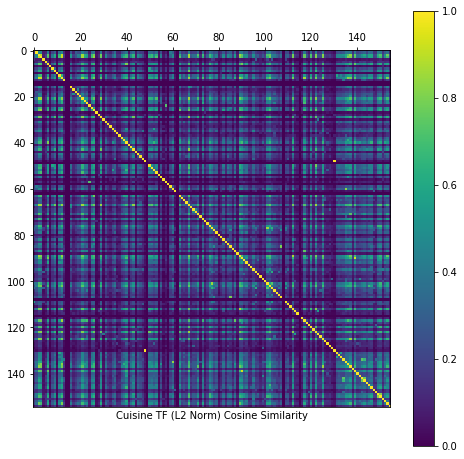

In [20]:
# Plot cosine similarity for all cuisines TFs
matrix = cosine_similarity(cuisineTermsL2Norm)
labels = cuisines.cuisine
_, _ = graphSimilarity(matrix, labels, "Cuisine TF (L2 Norm) Cosine Similarity", display_labels=False)
plot.show()

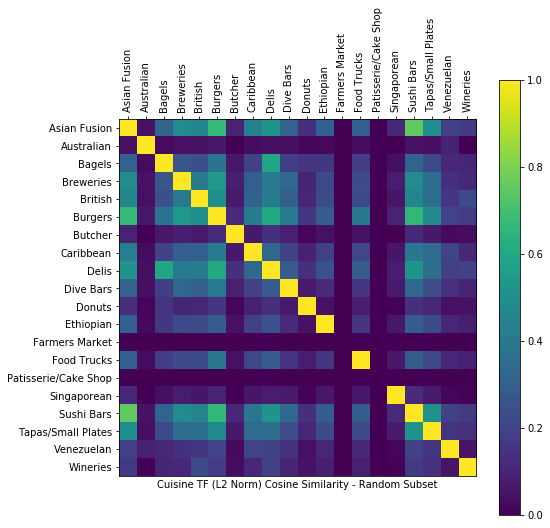

In [21]:
# Plot cosine similarity for random 20 cuisine TFs sample
SAMPLE_20 = sorted(random.sample(range(cuisines.shape[0]), 20))
matrix = cosine_similarity(cuisineTermsL2Norm[SAMPLE_20, :])
labels = cuisines.iloc[SAMPLE_20, ].cuisine
_, _ = graphSimilarity(matrix, labels, "Cuisine TF (L2 Norm) Cosine Similarity - Random Subset", display_labels=True)
plot.show()

*

## TF-IDF by Cuisine

*

In [36]:
# Create TF-IDF transformer from counts
tfToTfidf = TfidfTransformer(norm="l2", use_idf=True)

In [37]:
# Calculate TF-IDF for topics
cuisineTermsIDF = tfToTfidf.fit_transform(cuisineTerms)

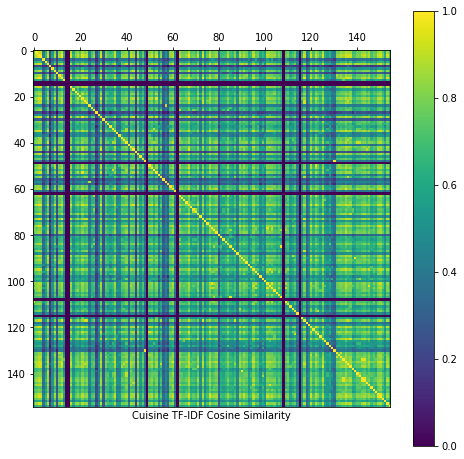

In [38]:
# Plot cosine similarity for all cuisines TF-IDF
matrix = cosine_similarity(cuisineTermsIDF)
labels = cuisines.cuisine
_, _ = graphSimilarity(matrix, labels, "Cuisine TF-IDF Cosine Similarity", display_labels=False)
plot.show()

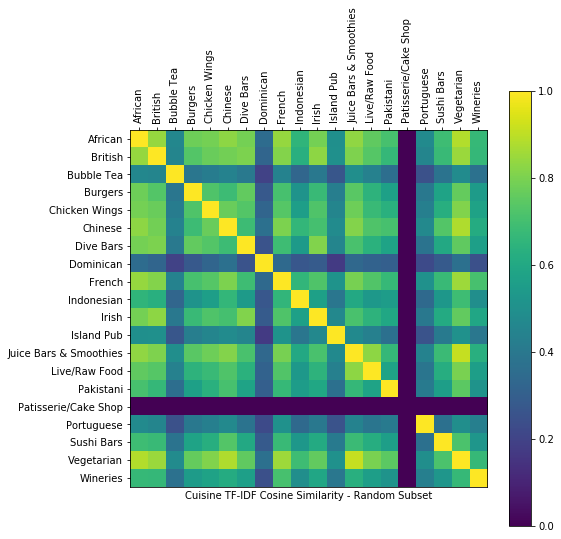

In [39]:
# Plot cosine similarity for random 20 cuisine TFs sample
SAMPLE_20 = sorted(random.sample(range(cuisines.shape[0]), 20))
matrix = cosine_similarity(cuisineTermsIDF[SAMPLE_20, :])
labels = cuisines.iloc[SAMPLE_20, ].cuisine
_, _ = graphSimilarity(matrix, labels, "Cuisine TF-IDF Cosine Similarity - Random Subset", display_labels=True)
plot.show()

*

# Determine Cuisine Similarity via LDA

*

In [25]:
# Calculate TF-IDF for terms
docTermsIDF = tfToTfidf.fit_transform(docTerms)

In [26]:
# Convert GenSim corpus from token matrix
corpus = matutils.Sparse2Corpus(docTermsIDF, documents_columns=False)

In [27]:
# Create a GenSim dictionary for documents; Note: Passes the
# vectorizer tokens as a single "document".
dictionary = corpora.Dictionary([tf.get_feature_names()])

In [28]:
%%time
%%capture --no-stdout

# Find topic using LDA
lda = models.ldamulticore.LdaMulticore(corpus, \
                                       num_topics=cuisines.shape[0],
                                       id2word=dict(dictionary.items()))

CPU times: user 48.2 s, sys: 9.59 s, total: 57.8 s
Wall time: 56.9 s


## Represent Cuisines as Topic Distributions

*

In [29]:
# Get topic distribution for each cuisine
rows, cols, vals = [], [], []
cuisineTerms = cuisineTerms.tocsr()
for i in range(cuisines.shape[0]):
    row = cuisineTerms.getrow(0)
    bow = list(zip(row.indices, row.data))
    for c, v in lda.get_document_topics(bow):
        rows.append(i)
        cols.append(c)
        vals.append(v)
cuisineTopics = sp.sparse.csr_matrix((vals, (rows, cols)))

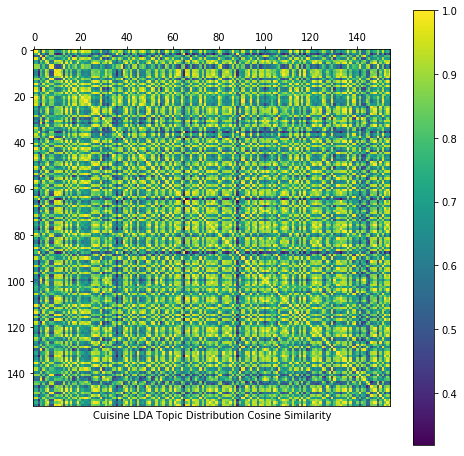

In [30]:
# Plot cosine similarity for all cuisines
matrix = cosine_similarity(cuisineTopics)
labels = cuisines.cuisine
_, _ = graphSimilarity(matrix, labels, "Cuisine LDA Topic Distribution Cosine Similarity", display_labels=False)
plot.show()

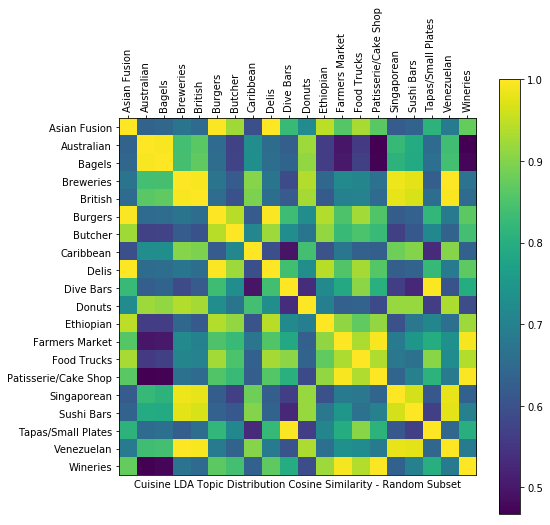

In [31]:
# Plot cosine similarity for random 20 cuisine sample
matrix = cosine_similarity(cuisineTopics[SAMPLE_20, :])
labels = cuisines.iloc[SAMPLE_20, ].cuisine
_, _ = graphSimilarity(matrix, labels, "Cuisine LDA Topic Distribution Cosine Similarity - Random Subset", display_labels=True)
plot.show()

# Cluster Similar Cuisines

*

## Cluster Cuisine Topics with K-Means

In [57]:
# Create and train K-Means clustering instance
cuisineTopicClustersKM = KMeans(n_clusters=10, random_state=42).fit(cuisineTopics)

In [65]:
# Add cluster labels and score to cuisines dataframe
cuisines["cluster_kmeans_topics_10"] = cuisineTopicClustersKM.labels_

AttributeError: 'Int64Index' object has no attribute 'apply'